<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Physique des ondes
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Paquet d'onde | Paquet d'onde & milieu absorbant
             </div>
        </div>
    </div>
</div>

<b>*ATTENTION!*
Les calculs engagés dans ce notebook sont longs et ne peuvent être raccourcis qu'au prix d'une erreur numérique parfois conséquente. Une exécution pas à pas est recommandée</b>

&nbsp;
<b>De même, les valeurs par défaut des diverses grandeurs `Num_x`, `L`, `lambda0` etc.. sont le fruit de nombreux tests. Vous vous éloignerez de ces valeurs *à vos risques et périls (numériques)*... </b>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib inline

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique
##  Propagation d'une onde électromagnétique

On étudie la propogation d'une onde électromagnétique dans le divers milieux en commençant par le plus simple : le vide.

&nbsp;
Le domaine étudié à une longueur de $L=50~\text{m}$, la longueur d'onde choisie est $\lambda_0=1~\text{m}$, et, pour rendre plus lisibles les résultats, on fixera la célérité des ondes dans le vide à $c=1~\text{m.s}^{-1}$. On en déduit la valeur de la pulsation associée dans le vide, noté $\omega_0$.

In [2]:
# Domaine de calcul
L = 50 # longueur

# Signal EMAG
E_amp = 1 # amplitude
lambda0 = 1 # longueur d'onde
sigma0 = 1 / lambda0 # nombre d'onde
c = 1 # célérité 
omega0=2*np.pi*sigma0*c # pulsation associée à la longueur d'onde

## Variables numériques
Les variables numériques spatiales, nombre de points et pas d'espace sont `Num_x` et `delta_x`, tandis que les variables temporelles sont `Num_t` et `delta_t`.

In [3]:
# Intégration spatiale
Num_x = 5001 # points de calcul
x=np.linspace(0,L,Num_x) # vecteur position
delta_x = x[1]-x[0] # intervalle spatial d'intégration


# Intégration temporelle
Num_t = 10001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

# Propagation d'une onde dans le métal (milieu non dispersif mais absorbant)

## Forme d'onde simple, fenêtre de Hann
On utilise à nouveau la fonction `Hann`, présentée dans le notebook sur les ondes électromagnétiques dans le vide.

In [4]:
x0=L/2 # position initiale de la forme d'onde

## Fenêtre de définition de la forme d'onde
def Hann(x,x0,H):
    func=np.zeros(len(x))
    for i in range(len(x)):
        if abs(x[i]-x0)<H/2:
            func[i]=.5*(1-np.cos(2*np.pi*(x[i]-x0+H/2)/H))
    return func

## Propagation dans un métal (milieu absorbant, non dispersif)
Dans un conducteur ohmique, où la loi d'Ohm locale est vérifiée : $\vec{j}=\gamma\vec{E}$, l'équation de propagation est modifiée et on a, cette fois : 
$$\dfrac{\partial^2 E}{\partial t^2}=c^2\dfrac{\partial^2 E}{\partial x^2}-c^2\mu_0\gamma \dfrac{\partial E}{\partial t}$$
où $\mu_0\epsilon_0c^2=1$.

### Approche numérique
Le code utilisé pour les ondes électromagnétiques dans le vide doit être modifié un peu plus profondément. La dérivée première par rapport au temps s'écrit $\frac{\partial E}{\partial t}(x_i,t_k)\simeq\frac{E^{k+1}_j - E^k_j}{\Delta t}$ et fait donc intervenir l'instant `E_new`. Il faut donc modifier la relation de récurrence qui le met à jour :
$$E^{k+1}=\dfrac{E^k\left(2+\mu_0\gamma c^2\Delta t\right)-E^{k-1}+c^2\Delta t ^2 \Delta E^k}{1+\mu_0\gamma\Delta_t c^2}$$

In [5]:
#################################
## PAQUET D'ONDE DANS UN METAL ##
#################################

# Nouvelle grandeurs physique à considérer
mu0 = 1
gamma = .1

# Intégration temporelle, répétée à nouveau pour éviter des confusions
Num_t = 20001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

## Forme d'onde à l'instant t, t-dt et t+dt, répétée à nouveau pour éviter des confusions 
x0=L/50
H=lambda0

E ,E0 = E_amp*Hann(x,x0,H)*np.cos(2*np.pi*x*4/lambda0),E_amp*Hann(x,x0,H)*np.cos(2*np.pi*x*4/lambda0) 
E_old  = E_amp*Hann(x,x0-c*delta_t,H)*np.cos(2*np.pi*(x+c*delta_t)*4/lambda0)
E_new  = E_amp*Hann(x,x0+c*delta_t,H)*np.cos(2*np.pi*(x-c*delta_t)*4/lambda0)

E_store=[] # liste dans laquelle on stocke quelques formes d'onde intermédiaires
time_store=[] # liste dans laquelle on stocke les instants correspondants

d2Ex=np.zeros(Num_x)

duree, k, time = 45, 0,0
while time < duree : 
    for i in range(Num_x-1):
        if i==0 :
            d2Ex[i] = (E[i+1]+0-2*E[i])/delta_x**2
        elif i==1 or i==Num_x-2 :
            d2Ex[i] = (E[i+1]+E[i-1]-2*E[i])/delta_x**2
        elif i==Num_x-1:
            d2Ex[i] = (0+E[i-1]-2*E[i])/delta_x**2
        else :
            d2Ex[i] = (-1/12*E[i+2]+4/3*E[i+1]-5/2*E[i]+4/3*E[i-1]-1/12*E[i-2])/delta_x**2
    E_new = (E*(2+mu0*gamma*delta_t*c**2) - E_old + ((c*delta_t)**2)*d2Ex)/(1+mu0*gamma*delta_t*c**2)
    E_old, E = E, E_new
    if k%(duree/(5*delta_t)) == 0 :
        E_store.append(E)
        time_store.append(time)
    k += 1
    time += delta_t

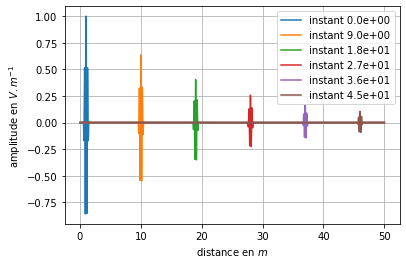

La vitesse de propagation moyenne de l'onde simulée est de  1.000e+00 m/s
L'écart-type de la vitesse de propagation de l'onde simulée est de  1.383e-04 m/s


In [6]:
plt.figure()
plt.grid(True)
for i in range(len(E_store)) :
    plt.plot(x,E_store[i], label="instant "+str(format(time_store[i], "#.1e")))
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.show()

# On ne prend pas en compte l'instant initial (distance nulle et division par 0)
pos = np.array([np.abs(x[np.argmax(abs(E0))]-x[np.argmax(abs(E_store[i]))]) for i in range(1,len(E_store))])
v_phi = np.array([pos[i]/((i+1)*duree/5) for i in range(len(pos))])

v_phi_moy=np.mean(v_phi)
v_phi_u=np.std(v_phi, ddof=1)
print("La vitesse de propagation moyenne de l'onde simulée est de ",format(v_phi_moy,"#.3e"),"m/s")
print("L'écart-type de la vitesse de propagation de l'onde simulée est de ",format(v_phi_u,"#.3e"),"m/s")

On constate une décroissance de l'amplitude, sans déformation longitudinale de l'onde. 
### Animation
Ce constat est encore plus frappant, lorsque l'on regarde l'animation ci-dessous faite sur la base des valeurs suivantes : 
`gamma=.3`, `mu0=1` et `H=10*lambda0`.

In [7]:
from IPython.display import Video

Video("prop_metal_paquet.mp4", width=640)

On peut remarquer une très légère réflexion qui augmente si la valeur de la conductivité augmente de manière conséquente.

In [8]:
from IPython.display import Video

Video("prop_metal_g3000.mp4", width=640)

On constate une décroissance de l'amplitude, sans déformation longitudinale de l'onde. On peut s'en convaincre en superposant les ondes captées aux instants $t_k$.

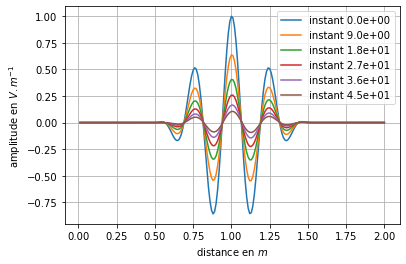

In [9]:
start=[int(x[np.argmax(abs(E0))] + i*c*duree/(5*delta_x)) for i in range(len(E_store))]
end = [start[i]+int(2*lambda0/delta_x) for i in range(len(E_store))]

end0=int(2*lambda0/delta_x)

plt.figure()
for i in range(len(start)):
    plt.plot(x[start[0]:end[0]],E_store[i][start[i]:end[i]], label="instant "+str(format(time_store[i], "#.1e")))
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.grid(True)
plt.show()

L'amplitude de l'onde décroît tout au long de sa propagation, et, si on cherche à modéliser cette décroissance par une forme exponentielle $\text{Amp}(x)=\text{Amp}(x_0)\text{e}^{-\frac{x}{\delta}}$, on trouve la valeur suivante : 

In [10]:
delta = []
for i in range(1,len(E_store)):
    ind0 = np.argmax(abs(E_store[0]))
    ind = np.argmax(abs(E_store[i]))
    delta.append((x[ind0]-x[ind])/np.log(E_store[i][ind]/E_store[0][ind0]))

print("L'épaisseur de peau peut être évaluée par :", format(np.mean(delta), "#.3e"), "m")
print("L'incertitude-type associée à cette épaisseur de peau est :", format(np.std(delta, ddof=1), "#.3e"), "m")


L'épaisseur de peau peut être évaluée par : 1.993e+01 m
L'incertitude-type associée à cette épaisseur de peau est : 3.174e-02 m
